In [312]:
import logging
import warnings
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [313]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
blue1 = '#3EA1C0'

from matplotlib.colors import ListedColormap

In [314]:
path_name = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_base_cap_restricted_400_72/base_'
years = [2023, 2024, 2025, 2026, 2027, 2028]#, 2029, 2030, 2031]#, 2032, 2033, 2034, 2035, 2036, 2037]
networks = [pypsa.Network(path_name + str(year) + '.nc') for year in years]
networks = dict(zip(years, networks))
first_year = years[0]
final_year = years[-1]

In [315]:
# Helper functions
def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    for carrier in carriers:
        production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6

    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex() + network.statistics.opex(aggregate_time="sum")).div(1e6)

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal' 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, green2, beige1, teal4, yellow, teal2, purple2, brown]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_marginal_cost(y, carrier):
    network = networks[y]
    marginal_cost= network.generators.loc[network.generators['carrier'] == carrier, 'marginal_cost'].iloc[0]
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))



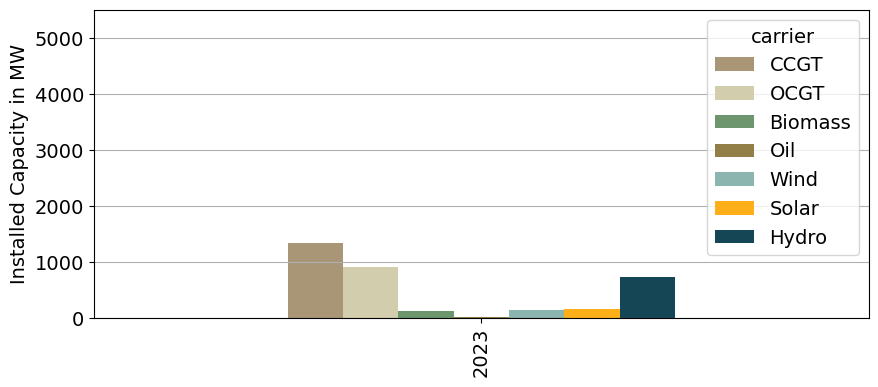

In [316]:
installed_capacity_23 = get_installed_capacity(first_year)
installed_capacity_23.index = [first_year]
installed_capacity_23 = rename_columns(installed_capacity_23)
installed_capacity_23.plot(kind='bar',color=get_colors(installed_capacity_23.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.ylim(0,5500)
plt.grid(axis='y')
plt.show()

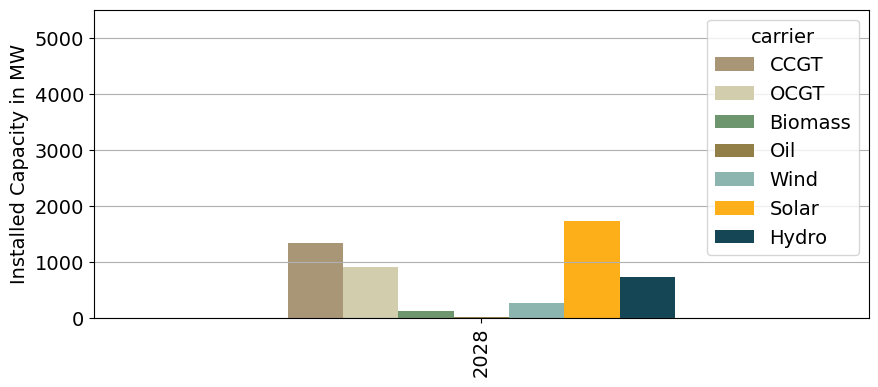

In [317]:
installed_capacity_37 = get_installed_capacity(final_year)
installed_capacity_37.index = [final_year]
installed_capacity_37 = rename_columns(installed_capacity_37)
installed_capacity_37.plot(kind='bar',color=get_colors(installed_capacity_37.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.grid(axis='y')
plt.ylim(0,5500)
plt.show()

In [318]:
yearly_difference = False
if yearly_difference:
    installed_capacities = []
    for year in years:
        year_capacity_df = get_installed_capacity(year)
        installed_capacities.append(year_capacity_df)

    all_capacities = pd.concat(installed_capacities)
    year_over_year_diff = all_capacities.diff().dropna()
    year_over_year_diff = rename_columns(year_over_year_diff)

    year_over_year_diff.plot(kind='bar', figsize=(12, 6), color=get_colors(year_over_year_diff.columns))
    plt.title('Year-over-Year Differences in Installed Capacity')
    plt.ylabel('Difference in Installed Capacity (MW)')
    plt.xlabel('Year')
    plt.ylim(0, 10)
    plt.show()

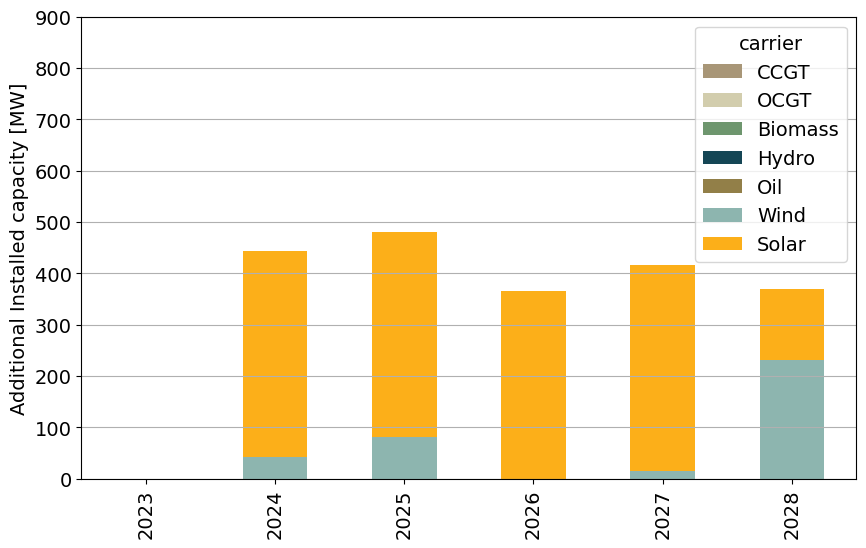

In [319]:
grouped_cap_change_B = get_new_installed(years)
grouped_cap_change_B = rename_columns(grouped_cap_change_B)
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(grouped_cap_change_B.columns))

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.ylim(0, 900)
plt.grid(axis = 'y',zorder = 0)

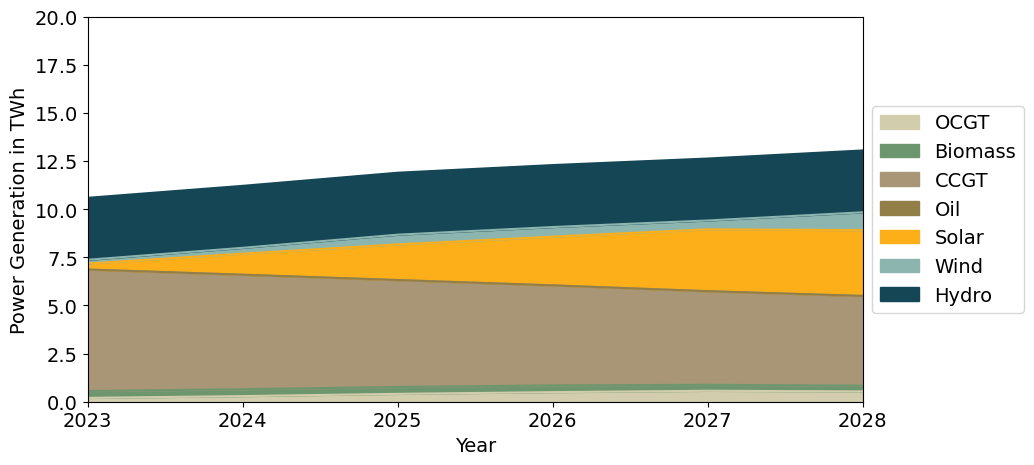

In [320]:
production_sources = [get_power_prod(year) for year in years]
production = pd.concat(production_sources)
production.index = years
production = production.astype('float32')

if 'load' in production:
  production.drop('load', axis=1, inplace=True)

#production['hydro'] += production.pop('ror')
#print(production)
production = rename_columns(production)
production.plot.area(stacked=True, color=get_colors(production.columns),figsize=(10, 5))

plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(first_year,final_year)
plt.ylim(0,20)
#plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

          OCGT   biomass      CCGT           oil     solar    onwind     hydro
2023  0.018716  0.033801  0.595881  8.601893e-14  0.029203  0.018527  0.303872


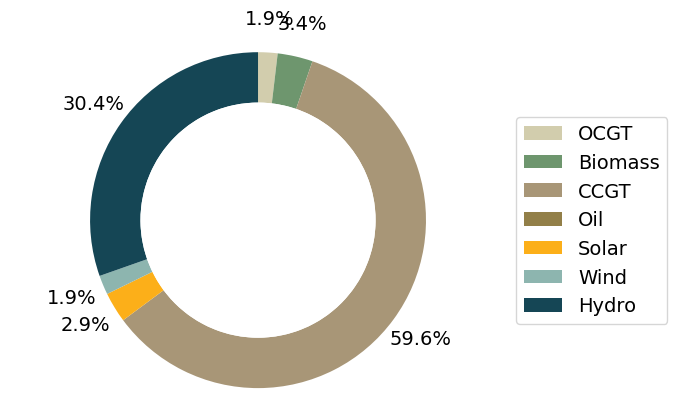

In [321]:
power_mix_df = get_power_mix(first_year)
print(power_mix_df)
plt.rcParams['font.size'] = 14
power_mix_df = rename_columns(power_mix_df)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)


plt.legend(power_mix_df.columns, loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

          OCGT   biomass      CCGT      oil     solar    onwind     hydro
2028  0.040996  0.022824  0.357088  0.00007  0.261719  0.071211  0.246092


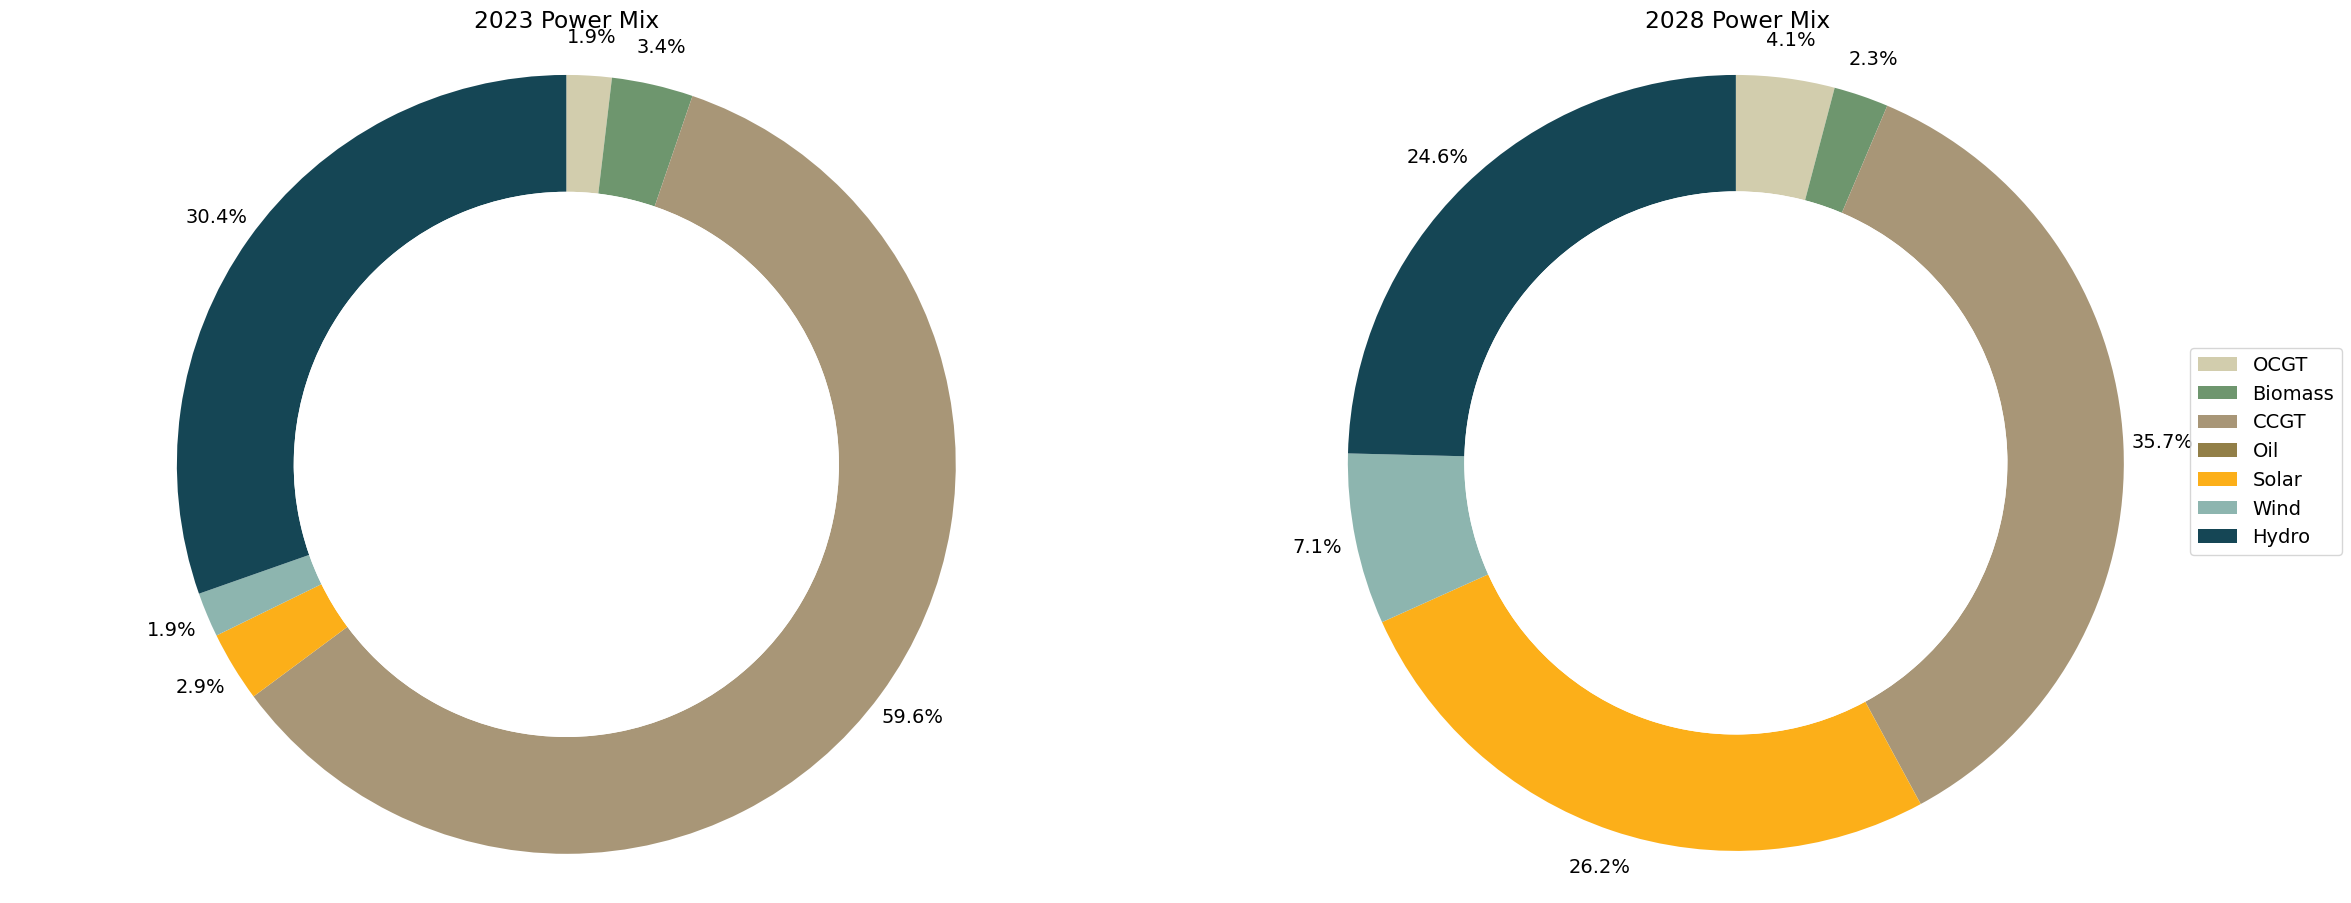

In [322]:
power_mix_first = get_power_mix(first_year)
power_mix_final = get_power_mix(final_year)
print(power_mix_final)

plt.rcParams['font.size'] = 14
power_mix_first = rename_columns(power_mix_first)
power_mix_final = rename_columns(power_mix_final)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_first.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_first.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_final.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_final.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title(str(first_year) +' Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title(str(final_year) +' Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(power_mix_first.columns, loc="center right", bbox_to_anchor=(1, 0.5))

plt.tight_layout(pad=3.0)
plt.show()

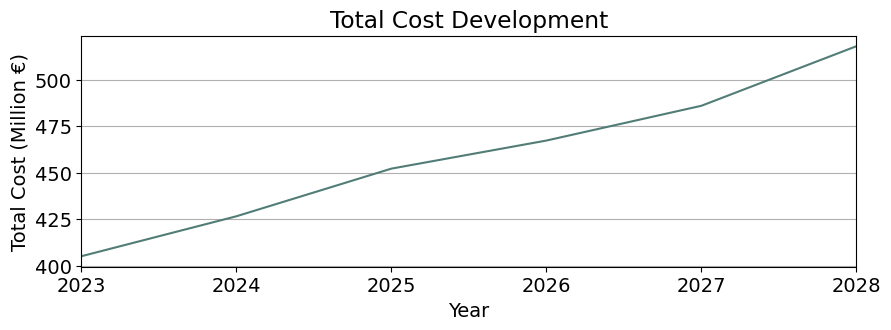

In [323]:
total_costs = [get_total_cost(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(360,700)
plt.grid(axis='y')
plt.show()

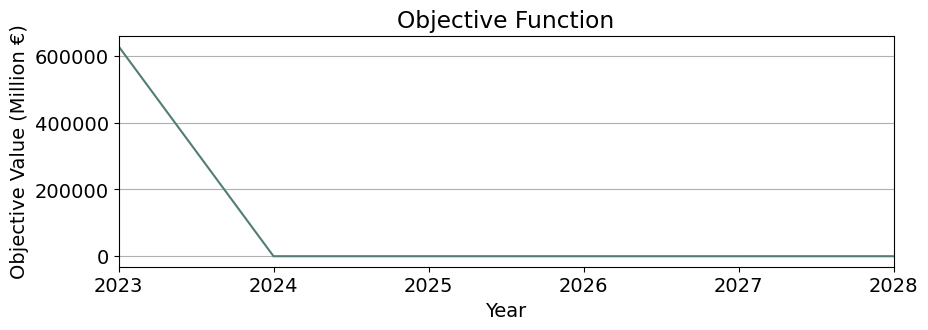

In [324]:
total_objective = [get_objective(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_objective, color=teal3)
plt.title('Objective Function')
plt.xlabel('Year')
plt.ylabel('Objective Value (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(70,250)
plt.grid(axis='y')
plt.show()

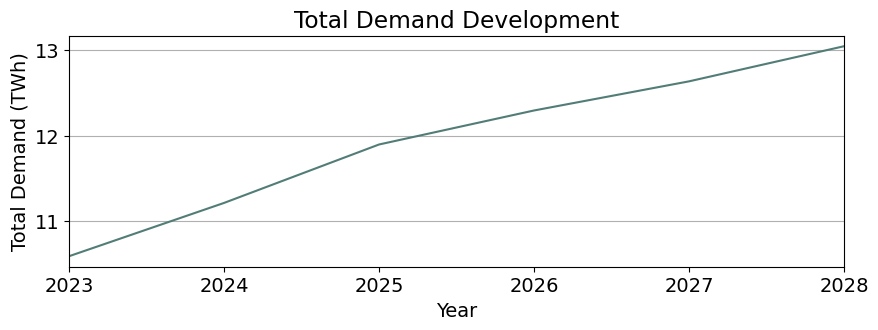

In [325]:
total_demand = [get_demand(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(first_year,final_year)
plt.grid(axis='y')
plt.show()

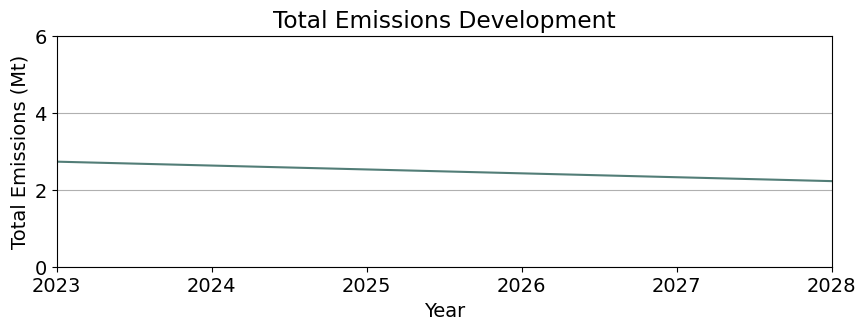

In [326]:
total_emissions = [get_emissions(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_emissions, color=teal3)
plt.title('Total Emissions Development')
plt.xlabel('Year')
plt.ylabel('Total Emissions (Mt)')
plt.xlim(first_year,final_year)
plt.ylim(0,6)
plt.grid(axis='y')
plt.show()

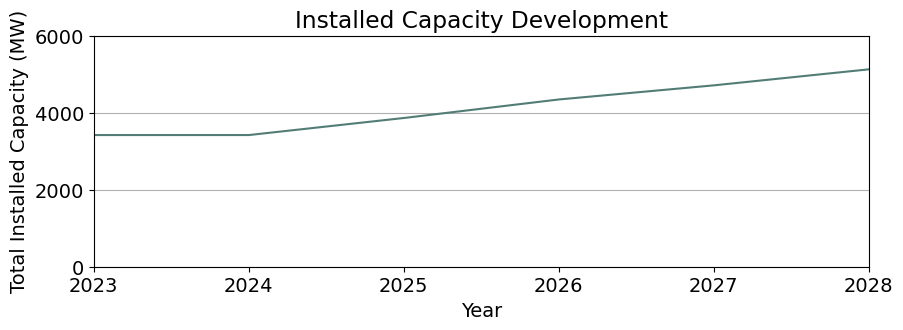

In [327]:
total_capacity = [get_installed_capacity(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

LL 107.23523723676249
CCGT:  102926.46176710262
OCGT:  11507.12282882468
Wind:  11421.34635062407
Solar:  59057.75505561876
Hydro:  61697.78070802337
Oil:  62.25178210844707
Biomass:  6599.497673273347
Battery:  -5.235353700960353


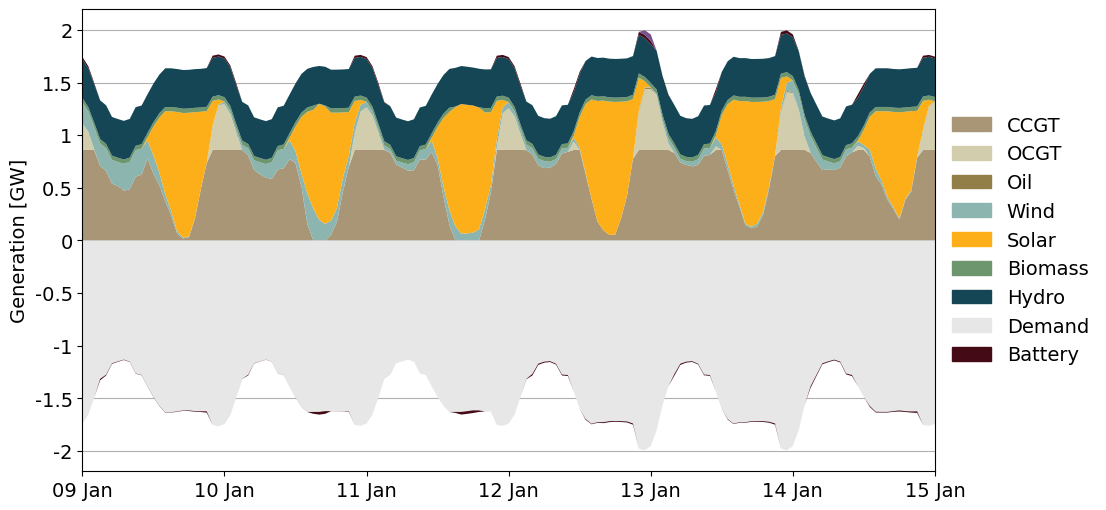

In [328]:
first_date = "2013-01-09"
second_date = "2013-01-15"
year = final_year

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro += get_snapshot_generation(year, first_date, second_date, 'hydro')
#geothermal = get_snapshot_generation(year, first_date, second_date, 'geothermal')
Battery = get_snapshot_generation(year, first_date, second_date, 'battery')
#H2 = get_snapshot_generation(year, first_date, second_date, 'H2')
demand = get_snapshot_demand(year, first_date, second_date)   

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9)
print('LL',LL.sum())

print('CCGT: ', CCGT.sum())
print('OCGT: ', OCGT.sum())
print('Wind: ', Wind.sum())
print('Solar: ', Solar.sum())
print('Hydro: ', Hydro.sum())
print('Oil: ', Oil.sum())
#print('Geothermal ',geothermal.sum())
print('Biomass: ', Biomass.sum())
print('Battery: ', Battery.sum())
#print('H2: ', H2.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, pbattery, LL,
                  colors=[beige2,beige3,beige1,teal4,yellow,green2,teal2,brown, purple2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[grey1, brown], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
#ax.set_ylim(-3000, 3000)



CCGT_patch = mpatches.Patch(color=beige2, label ='CCGT')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
oil_patch = mpatches.Patch(color=beige1, label = 'Oil')
wind_patch = mpatches.Patch(color=teal4, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green2, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=grey1, label ='Demand')
battery_patch = mpatches.Patch(color=brown, label ='Battery')
LL_patch = mpatches.Patch(color=purple2, label ='Lost Load')
#H2_patch = mpatches.Patch(color=red2, label ='H2')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch, battery_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)

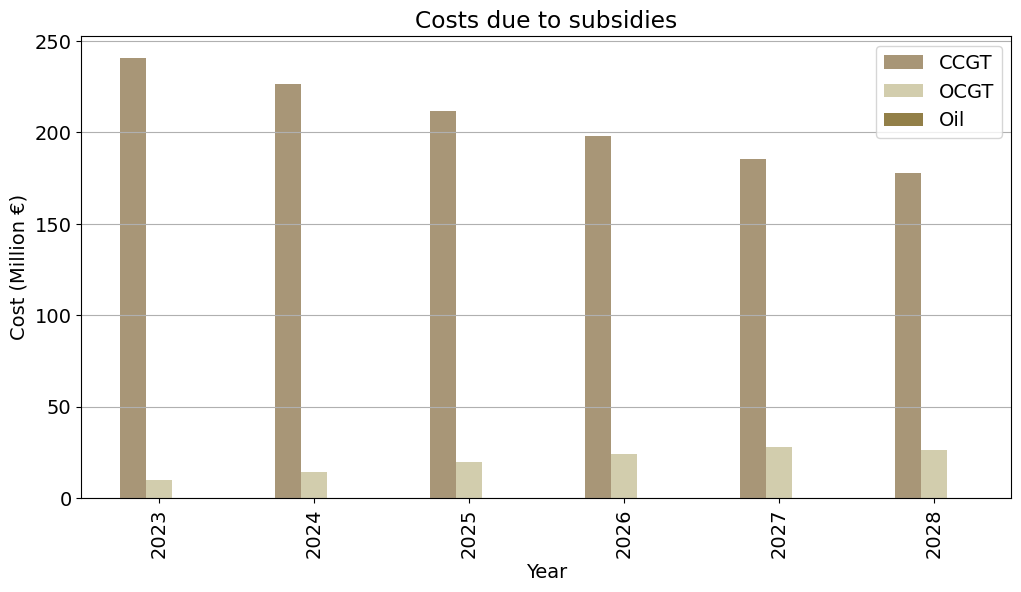

In [348]:
subsidies = get_subsidies()
cost_of_subsidies = {}

for year in years:
    for (subsidy_year, carrier), subsidy_rate in subsidies.items():
        if carrier == 'oil':
            carrier = 'Oil'
        # Check if we're looking at the correct year for the subsidy
        if subsidy_year == year:
            # Initialize a dictionary for this year if not already present
            if year not in cost_of_subsidies:
                cost_of_subsidies[year] = {}

            cost_of_subsidies[year][carrier] = 0

            # Check if the carrier is present in the production DataFrame
            if carrier in production.columns:
                # Calculate and store the cost of subsidies for this carrier in this year
                cost_of_subsidies[year][carrier] = subsidy_rate * production.loc[year,carrier]

cost_df = pd.DataFrame()
for year, carriers in cost_of_subsidies.items():
    for carrier, cost in carriers.items():
        cost_df.loc[year, carrier] = cost
cost_df = rename_columns(cost_df)
cost_df.plot(kind='bar', figsize=(12, 6), color=get_colors(cost_df.columns))
plt.title('Costs due to subsidies')
plt.ylabel('Cost (Million €)')
plt.xlabel('Year')
plt.grid(axis='y')
plt.show()

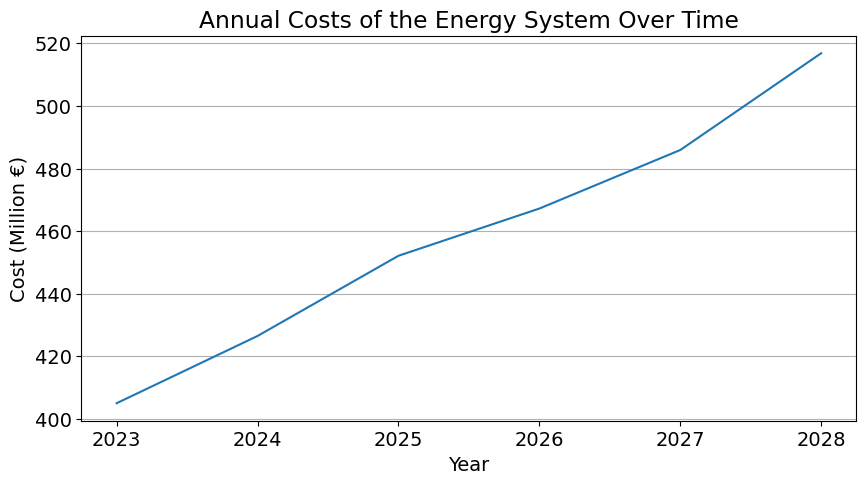

In [350]:
discount_rate = 0.04

lifetime = {  # example lifetimes in years
    'solar': 25,
    'wind': 20,
    'gas': 30,
    # add lifetimes for all technologies
}

annual_costs_list = []

for year in years:
    network = networks[year]  # Adjust the path as necessary
    stats = network.statistics()
    # Calculate annual Capital Expenditure and Operational Expenditure for all relevant categories
    annual_capex = 0
    annual_opex = 0

    for category in ['Generator', 'Load', 'StorageUnit', 'Store']:
        if 'Capital Expenditure' in stats.columns:
            annual_capex += stats.loc[category, 'Capital Expenditure'].sum()
        if 'Operational Expenditure' in stats.columns:
            annual_opex += stats.loc[category, 'Operational Expenditure'].sum()
    
    annual_costs_list.append(annual_capex + annual_opex)

# Calculate the NPV of the annual costs
annual_costs_npv = npv_of_costs(annual_costs_list, discount_rate)

# Convert the list of costs to a pandas DataFrame for easy plotting
annual_costs_df = pd.DataFrame({'Year': years, 'Cost': annual_costs_list})

# Plotting the annual costs as a line graph
plt.figure(figsize=(10, 5))
plt.plot(annual_costs_df['Year'], annual_costs_df['Cost']/1e6)
plt.title('Annual Costs of the Energy System Over Time')
plt.ylabel('Cost (Million €)')
plt.xlabel('Year')
plt.grid(axis='y')
plt.show()

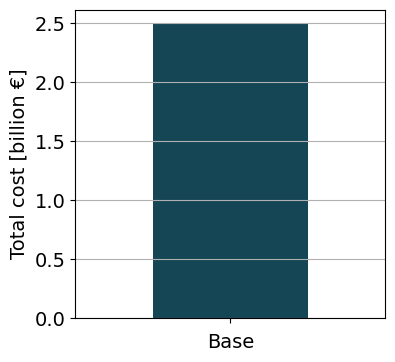

In [347]:
annual_costs_npv_series = pd.Series(annual_costs_npv/1e9, index=[''])
annual_costs_npv_series.plot(kind='bar', figsize=(4, 4), color=teal2)
plt.ylabel('Total cost [billion €]')
#plt.ylim(0,18)
plt.xlabel('Base')
plt.grid(axis='y')
plt.show()

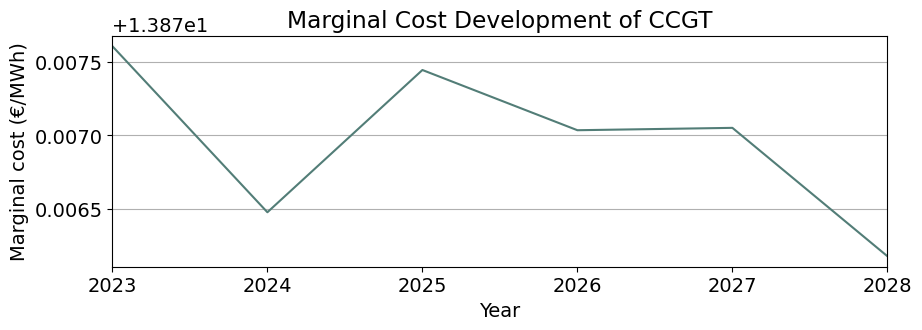

In [334]:
marginal_cost_CCGT = [get_marginal_cost(year,'CCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_CCGT, color=teal3)
plt.title('Marginal Cost Development of CCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
#plt.ylim(0,30)
plt.grid(axis='y')
plt.show()

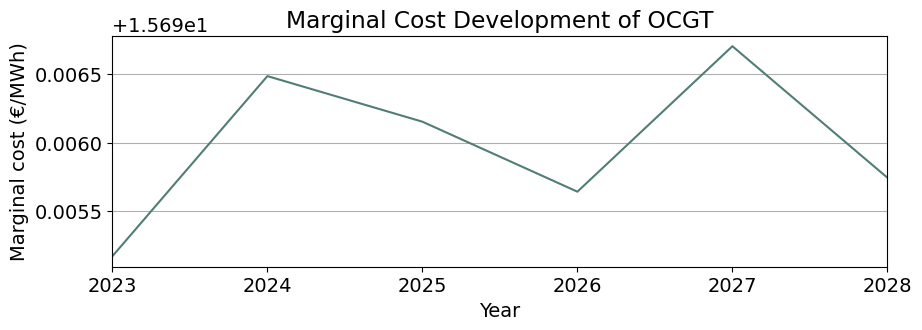

In [335]:
marginal_cost_OCGT = [get_marginal_cost(year,'OCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_OCGT, color=teal3)
plt.title('Marginal Cost Development of OCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
#plt.ylim(0,30)
plt.grid(axis='y')
plt.show()

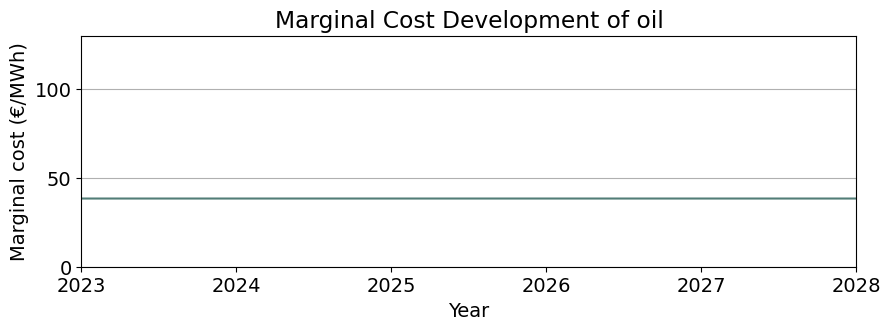

In [336]:
marginal_cost_oil = [get_marginal_cost(year,'oil') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_oil, color=teal3)
plt.title('Marginal Cost Development of oil')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,130)
plt.grid(axis='y')
plt.show()

In [329]:
n = networks[final_year]
capital_cost_gen = n.generators.groupby('carrier').capital_cost.mean().drop('load')
capital_cost_gen_series = pd.Series(capital_cost_gen, index=capital_cost_gen.index)
capital_cost_storage = n.storage_units.groupby('carrier').capital_cost.mean()
capital_cost_storage_series = pd.Series(capital_cost_storage, index=capital_cost_storage.index)
capital_cost = pd.concat([capital_cost_gen, capital_cost_storage])

grouped_cap_change_B = get_new_installed(years)

i =0.04
data_add_cost = {}
carriers = [col for col in grouped_cap_change_B.columns if col != year]
for carrier in carriers:
    carrier_values = []

    for y in np.arange(first_year, final_year+1):
        value = 0
        for rest in np.arange(final_year+1-y):
            if rest > 0:
                value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
        carrier_values.append(value)
    data_add_cost[carrier] = carrier_values

add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(first_year, final_year+1))

In [330]:
objective_value_list_B = []
for y in range(first_year,final_year):
    net=networks[y]
    objective_value_list_B.append(net.objective)

data={"year":[],"total_costs":[]}
for y in np.arange(first_year,final_year):
    data["year"].append(y)
    data["total_costs"].append(objective_value_list_B[y-first_year]/((1+i)**(y-first_year))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-first_year))) #objective_value_B[y]+

total_costs_B=pd.DataFrame(data)
total_costs_B.index=total_costs_B["year"]
total_costs_B.drop("year",axis=1,inplace=True)

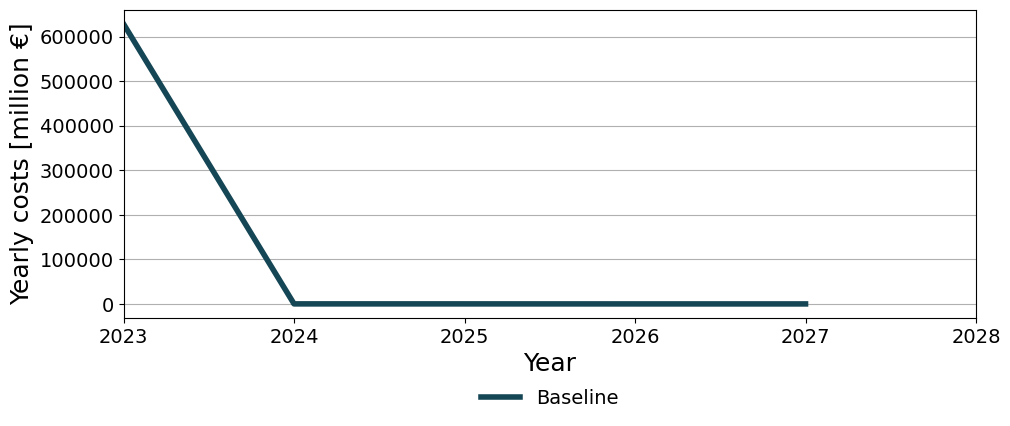

In [331]:
(total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = teal2, linewidth = 4, zorder = 2, label = 'Baseline')
plt.ylabel('Yearly costs [million €]',fontsize = 18)
plt.xlabel('Year',fontsize = 18)
plt.grid(axis='y')
plt.xlim(first_year,final_year)
#plt.ylim(0,400)
plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)


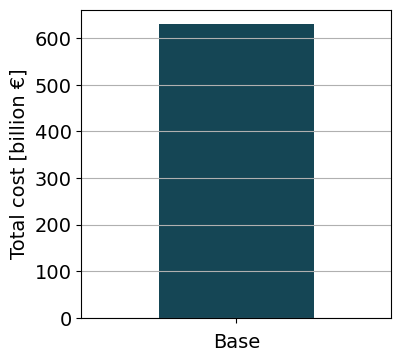

In [332]:
total_cost = total_costs_B.sum() / 1e9
total_cost_series = pd.Series(total_cost.iloc[0], index=[''])
total_cost_series.plot(kind='bar', figsize=(4, 4), color=teal2)
plt.ylabel('Total cost [billion €]')
#plt.ylim(0,18)
plt.xlabel('Base')
plt.grid(axis='y')
plt.show()